# Efficient Duplicate Detection with Embeddings and FAISS

Embeddings are numerical representations of data, such as text, that capture semantic meaning in a dense vector space. By leveraging embeddings, we can efficiently compare and analyze data points based on their contextual similarity. In this notebook, we utilize embeddings generated by state-of-the-art models from the SentenceTransformers library to deduplicate textual data. FAISS, a library optimized for similarity search, enables us to perform fast and scalable nearest neighbor searches on these embeddings, making it ideal for large datasets. This approach ensures high accuracy in identifying duplicates while maintaining computational efficiency.

In [1]:
import os
import sys
from typing import List
from types import SimpleNamespace
from itertools import product

ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

import faiss
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

from utils import *

/Users/michalszczygiel/workspace/dupli-gone/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = prepare_dataset()

Loading datasets: 100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


In [3]:
texts = df['abstract'].to_list()
labels = df['label'].to_list()

In [4]:
class EmbeddingDeduplicator:
    '''
    A class to deduplicate text embeddings using FAISS.
    '''
    def __init__(self, model_name: str = 'sentence-transformers/all-MiniLM-L6-v2', dimension: int = 384, top_k: int = 3, threshold: float = 0.85, bacth_size: int = 32):
        self.model = SentenceTransformer(model_name, cache_folder='.cache')
        self.dimension = dimension
        self.top_k = top_k
        self.threshold = threshold
        self.batch_size = bacth_size
    
    def predict(self, texts: List[str]) -> np.ndarray:
        embeddings = self.model.encode(texts, show_progress_bar=False, normalize_embeddings=True, batch_size=self.batch_size)
        
        index = faiss.IndexFlatIP(self.dimension)
        index.add(embeddings)

        similarities, neighbors = index.search(embeddings, self.top_k)

        duplicates = set()

        for i in range(len(texts)):
            for j, sim in zip(neighbors[i][1:], similarities[i][1:]):
                if sim > self.threshold:
                        duplicates.add(i)
                        duplicates.add(j)

        indices = np.zeros(len(texts), dtype=int)
        indices[list(duplicates)] = 1
        return indices

## Ablation Study: Impact of Embedding Models on Deduplication Performance

The models below are sourced from the [original SentenceTransformers models](https://sbert.net/docs/sentence_transformer/pretrained_models.html#original-models).

| Model | Accuracy | Precision | Recall | F1 Score | Prediction Time (s) |
|-------|----------|-----------|--------|----------|----------------------|
| sentence-transformers/all-MiniLM-L12-v2    | 0.92823   | 0.96335    | 0.89033 | 0.92540   | 19.54994                |
| sentence-transformers/multi-qa-distilbert-cos-v1    | 0.95550   | 0.97380    | 0.93619 | 0.95462   | 107.48424                |
| sentence-transformers/all-MiniLM-L6-v2    | 0.94592   | 0.96905    | 0.92126 | 0.94455   | 22.15212                |
| sentence-transformers/multi-qa-MiniLM-L6-cos-v1    | 0.97204   | 0.97487    | 0.96907 | 0.97196   | 48.73280                |
| sentence-transformers/paraphrase-albert-small-v2    | 0.92310   | 0.97754    | 0.86610 | 0.91845   | 27.69109                |
| sentence-transformers/paraphrase-MiniLM-L3-v2    | 0.92860   | 0.97940    | 0.87562 | 0.92461   | 6.62277                |


In [ ]:
models = [
    SimpleNamespace(name='sentence-transformers/all-MiniLM-L12-v2', dimension=384),
    SimpleNamespace(name='sentence-transformers/multi-qa-distilbert-cos-v1', dimension=768),
    SimpleNamespace(name='sentence-transformers/all-MiniLM-L6-v2', dimension=384),
    SimpleNamespace(name='sentence-transformers/multi-qa-MiniLM-L6-cos-v1', dimension=384),
    SimpleNamespace(name='sentence-transformers/paraphrase-albert-small-v2', dimension=768),
    SimpleNamespace(name='sentence-transformers/paraphrase-MiniLM-L3-v2', dimension=384),
]

for model in models:
    print(f'Evaluating model: {model}')
    deduplicator = EmbeddingDeduplicator(model_name=model.name, dimension=model.dimension, threshold=0.95, top_k=3)
    benchmark = Benchmark(deduplicator)
    benchmark.evaluate(texts, labels, verbose=True)
    print('\n')

Evaluating model: namespace(name='sentence-transformers/all-MiniLM-L12-v2', dimension=384)
Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92823
Precision                   0.96335
Recall                      0.89033
F1                          0.92540
Prediction_time_sec        19.54994
Samples                  9347.00000
Duplicates               4623.00000


Evaluating model: namespace(name='sentence-transformers/multi-qa-distilbert-cos-v1', dimension=768)
Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.95550
Precision                   0.97380
Recall                      0.93619
F1                          0.95462
Prediction_time_sec       107.48424
Samples                  9347.00000
Duplicates               4623.00000


Evaluating model: namespace(name='sentence-transformers/all-MiniLM-L6-v2', dimension=384)
Summary:
Metric                        Value
----

## Ablation Study: Sensitivity to Threshold

Since model **sentence-transformers/paraphrase-MiniLM-L3-v2** achieved the fastest prediction time among all evaluated models, all subsequent experiments in this study will be conducted using this model.

In [18]:
thresholds = np.linspace(0.80, 1.00, 11)  # [0.80, 0.82, ..., 1.00]

results = []

for threshold in tqdm(thresholds, desc=f'Processing thresholds'):
    deduplicator = EmbeddingDeduplicator(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=threshold,
        top_k=3
    )
    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts, labels, verbose=False)
    results.append(metrics['accuracy'])

Processing thresholds: 100%|██████████| 11/11 [01:40<00:00,  9.16s/it]


/var/folders/2y/vxc21f554ng3_y3tbvy3892r0000gn/T/ipykernel_9051/1814682704.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


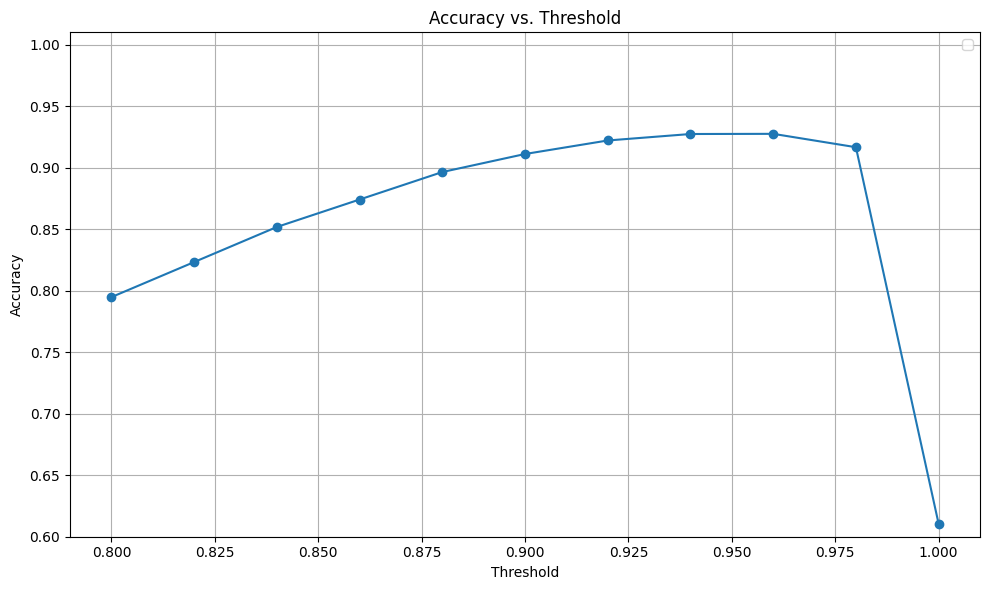

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(thresholds, results, marker='o')

plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.ylim(0.60, 1.01)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The result of this ablation showed that for a threshold of 0.96, the highest performance was achieved.

## Ablation Study: Influence of k on prediction time

In [22]:
top_k_values = [2, 3, 4, 5]

for top_k in top_k_values:
    print(f'Evaluating top_k: {top_k}')
    deduplicator = EmbeddingDeduplicator(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=top_k
    )
    benchmark = Benchmark(deduplicator)
    benchmark.evaluate(texts, labels, verbose=True)
    print('\n')

Evaluating top_k: 2
Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92749
Precision                   0.98256
Recall                      0.87043
F1                          0.92310
Prediction_time_sec         6.90895
Samples                  9347.00000
Duplicates               4623.00000


Evaluating top_k: 3
Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92749
Precision                   0.98256
Recall                      0.87043
F1                          0.92310
Prediction_time_sec         6.76872
Samples                  9347.00000
Duplicates               4623.00000


Evaluating top_k: 4
Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92749
Precision                   0.98256
Recall                      0.87043
F1                          0.92310
Prediction_time_sec         6.77775
Samples  

The number of nearest neighbors (*k*) to be returned for each query does not affect the prediction time.

## Ablation Study: Influence of Batch Size on Deduplication Performance

In [25]:
batch_sizes = [8, 16, 32, 64, 128, 256, 512]

results = []

for batch_size in tqdm(batch_sizes, desc='Processing batch sizes'):
    deduplicator = EmbeddingDeduplicator(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=3,
        bacth_size=batch_size
    )
    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts, labels, verbose=False)
    results.append(metrics['prediction_time_sec'])

Processing batch sizes: 100%|██████████| 7/7 [01:01<00:00,  8.84s/it]


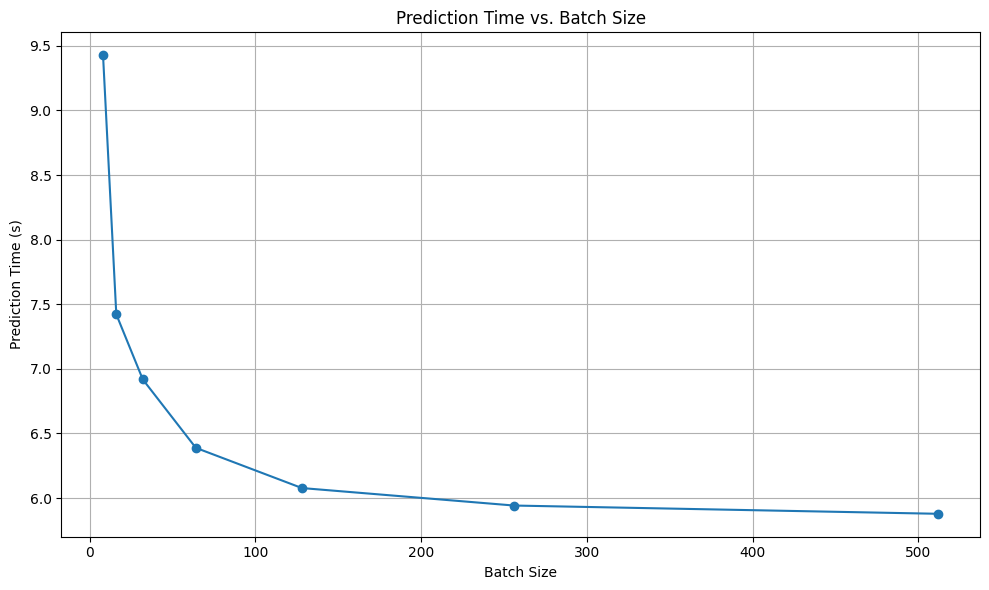

In [26]:
plt.figure(figsize=(10, 6))

plt.plot(batch_sizes, results, marker='o')

plt.title('Prediction Time vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Prediction Time (s)')
plt.grid(True)
plt.tight_layout()
plt.show()

The results show that the fastest prediction time was achieved with a batch size of `512`. However, the batch size of `256` performed almost as well, so we select `256` for further experiments.

## Ablation Study: The Impact of Different FAISS Index Types on Deduplication Effectiveness

A description of all available FAISS index types can be found [here](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes).

Some FAISS index types require training before they can be used for similarity search. Therefore, the dataset is split into a training set (80%) and a test set (20%) to ensure proper index preparation and evaluation.

In [ ]:
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.8, random_state=42, stratify=labels
)

In [ ]:
class BaseEmbeddingDeduplicator:
    """
    Base class: handles encoding and duplicate‐marking logic.
    Override `_build_index()` to return an untrained FAISS index.
    """
    def __init__(
        self,
        model_name: str = 'sentence-transformers/all-MiniLM-L6-v2',
        dimension: int = 384,
        top_k: int = 3,
        threshold: float = 0.85,
        batch_size: int = 32
    ):
        self.model = SentenceTransformer(model_name, cache_folder='.cache')
        self.dimension = dimension
        self.top_k = top_k
        self.threshold = threshold
        self.batch_size = batch_size
        self.index: faiss.Index = None

    def train_index(self, texts: List[str]) -> None:
        """
        Trains the index.
        Must be called once before `predict`.
        """
        self.index = self._build_index()
        if hasattr(self.index, 'train'):
            embeddings = self.model.encode(texts, show_progress_bar=False, normalize_embeddings=True, batch_size=self.batch_size)
            self.index.train(embeddings)

    def predict(self, texts: List[str]) -> np.ndarray:
        """
        Encode texts, search against the trained index,
        and return a binary mask of duplicates.
        """
        if self.index is None:
            raise RuntimeError("Call train_index(...) first")
        embeddings = self.model.encode(texts, show_progress_bar=False, normalize_embeddings=True, batch_size=self.batch_size)
        self.index.add(embeddings)

        similarities, neighbors = self.index.search(embeddings, self.top_k)

        duplicates = set()

        for i in range(len(texts)):
            for j, sim in zip(neighbors[i][1:], similarities[i][1:]):
                if sim > self.threshold:
                        duplicates.add(i)
                        duplicates.add(j)

        indices = np.zeros(len(texts), dtype=int)
        indices[list(duplicates)] = 1
        return indices

    def _build_index(self) -> faiss.Index:
        raise NotImplementedError

In [ ]:
class DeduplicatorFlatIP(BaseEmbeddingDeduplicator):
    def _build_index(self) -> faiss.Index:
        return faiss.IndexFlatIP(self.dimension)

In [ ]:
class DeduplicatorFlatL2(BaseEmbeddingDeduplicator):
    def _build_index(self) -> faiss.Index:
        return faiss.IndexFlatL2(self.dimension)

In [ ]:
class DeduplicatorHNSW(BaseEmbeddingDeduplicator):
    def __init__(self, M: int = 16, ef_search: int = 64, ef_construction: int = 64, **kwargs):
        super().__init__(**kwargs)
        self.M = M
        self.ef_search = ef_search
        self.ef_construction = ef_construction

    def _build_index(self) -> faiss.Index:
        index = faiss.IndexHNSWFlat(self.dimension, self.M)
        index.hnsw.efSearch = self.ef_search
        index.hnsw.efConstruction = self.ef_construction
        return index

In [ ]:
m_values = [2, 4, 8, 16, 32]
ef_construction_values = [2, 4, 8, 16, 32]
ef_search_values = [2, 4, 8, 16, 32]

results = []

for M, ef_construction, ef_search in tqdm(
    list(product(m_values, ef_construction_values, ef_search_values)),
    desc="Grid search for DeduplicatorHNSW"
):
    deduplicator = DeduplicatorHNSW(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=3,
        batch_size=256,
        M=M,
        ef_construction=ef_construction,
        ef_search=ef_search
    )

    deduplicator.train_index(texts_train)

    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts_test, labels_test, verbose=False)

    metrics.update({
        'M': M,
        'ef_construction': ef_construction,
        'ef_search': ef_search
    })
    results.append(metrics)

results_df = pd.DataFrame(results)

if 'f1' in results_df.columns:
    results_df = results_df.sort_values(by='f1', ascending=False)

print(results_df.head())


Grid search for DeduplicatorHNSW: 100%|██████████| 125/125 [16:55<00:00,  8.12s/it]

    accuracy  precision    recall        f1  prediction_time_sec  samples  \
22  0.510313   0.513256  0.399297  0.449161             4.921330     7478   
20  0.496259   0.495468  0.409029  0.448118             4.860470     7478   
21  0.500435   0.500540  0.403623  0.446887             4.798443     7478   
15  0.492028   0.490447  0.409300  0.446214             4.986708     7478   
16  0.489382   0.486971  0.396864  0.437324             4.785474     7478   

    duplicates  M  ef_construction  ef_search  
22        3699  2               32          8  
20        3699  2               32          2  
21        3699  2               32          4  
15        3699  2               16          2  
16        3699  2               16          4  


In [ ]:
class DeduplicatorLSH(BaseEmbeddingDeduplicator):
    def __init__(self, nbits: int = 512, **kwargs):
        super().__init__(**kwargs)
        self.nbits = nbits

    def _build_index(self) -> faiss.Index:
        return faiss.IndexLSH(self.dimension, self.nbits)

In [ ]:
nbits_values = [16, 32, 64, 128, 256, 512, 768, 1024]

results = []

for nbits in tqdm(nbits_values, desc="Grid search for DeduplicatorLSH"):
    deduplicator = DeduplicatorLSH(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=3,
        batch_size=256,
        nbits=nbits
    )

    deduplicator.train_index(texts_train)

    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts_test, labels_test, verbose=False)

    metrics.update({
        'nbits': nbits
    })
    results.append(metrics)

results_df = pd.DataFrame(results)

if 'f1' in results_df.columns:
    results_df = results_df.sort_values(by='f1', ascending=False)

print(results_df.head())


Grid search for DeduplicatorLSH: 100%|██████████| 8/8 [01:00<00:00,  7.59s/it]

   accuracy  precision    recall        f1  prediction_time_sec  samples  \
5  0.459448   0.478867  0.918897  0.629619             4.758464     7478   
4  0.458502   0.478353  0.917005  0.628730             4.701243     7478   
6  0.458367   0.478279  0.916734  0.628603             4.763019     7478   
7  0.456880   0.477469  0.913760  0.627204             4.735452     7478   
3  0.456069   0.477025  0.912138  0.626439             4.693148     7478   

   duplicates  nbits  
5        3699    512  
4        3699    256  
6        3699    768  
7        3699   1024  
3        3699    128  


In [ ]:
class DeduplicatorIVFFlat(BaseEmbeddingDeduplicator):
    def __init__(self, nlist: int = 256, **kwargs):
        super().__init__(**kwargs)
        self.nlist = nlist

    def _build_index(self) -> faiss.Index:
        return faiss.index_factory(
            self.dimension,
            f"IVF{self.nlist},Flat",
            faiss.METRIC_INNER_PRODUCT
        )

In [ ]:
nlist_values = [64, 128, 256, 512, 1024]

results = []

for nlist in tqdm(nlist_values, desc="Grid search for DeduplicatorIVFFlat"):
    deduplicator = DeduplicatorIVFFlat(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=3,
        batch_size=256,
        nlist=nlist
    )

    deduplicator.train_index(texts_train)

    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts_test, labels_test, verbose=False)

    metrics.update({
        'nlist': nlist
    })
    results.append(metrics)

results_df = pd.DataFrame(results)

if 'f1' in results_df.columns:
    results_df = results_df.sort_values(by='f1', ascending=False)

print(results_df.head())


Grid search for DeduplicatorIVFFlat: 100%|██████████| 5/5 [00:38<00:00,  7.79s/it]

   accuracy  precision    recall        f1  prediction_time_sec  samples  \
1  0.878333   0.985401  0.768045  0.863252             4.692130     7478   
0  0.877390   0.985036  0.766423  0.862086             4.780523     7478   
2  0.876294   0.986653  0.762909  0.860474             4.755471     7478   
3  0.876035   0.985315  0.763450  0.860308             4.713804     7478   
4  0.874255   0.987925  0.757772  0.857677             4.783024     7478   

   duplicates  nlist  
1        3699    128  
0        3699     64  
2        3699    256  
3        3699    512  
4        3699   1024  


In [ ]:
class DeduplicatorIVFPQ(BaseEmbeddingDeduplicator):
    def __init__(self, nlist: int = 256, M: int = 8, nbits: int = 8, **kwargs):
        super().__init__(**kwargs)
        self.nlist, self.M, self.nbits = nlist, M, nbits

    def _build_index(self) -> faiss.Index:
        spec = f"IVF{self.nlist},PQ{self.M}"
        return faiss.index_factory(self.dimension, spec, faiss.METRIC_INNER_PRODUCT)

In [ ]:
nlist_values = [128, 256, 512]
M_values = [2, 4, 8, 16]
nbits_values = [4, 6, 8]

results = []

for nlist, M, nbits in tqdm(list(product(nlist_values, M_values, nbits_values)), desc="Grid search for DeduplicatorIVFPQ"):
    if 384 % M != 0:
        continue

    deduplicator = DeduplicatorIVFPQ(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=3,
        batch_size=256,
        nlist=nlist,
        M=M,
        nbits=nbits
    )

    deduplicator.train_index(texts_train)

    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts_test, labels_test, verbose=False)

    metrics.update({
        'nlist': nlist,
        'M': M,
        'nbits': nbits
    })
    results.append(metrics)

results_df = pd.DataFrame(results)

if 'f1' in results_df.columns:
    results_df = results_df.sort_values(by='f1', ascending=False)

print(results_df.head())

Grid search for DeduplicatorIVFPQ:   0%|          | 0/36 [00:00<?, ?it/s]WARNING clustering 1869 points to 128 centroids: please provide at least 4992 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
Grid search for DeduplicatorIVFPQ:   3%|▎         | 1/36 [00:09<05:30,  9.45s/it]WARNING clustering 1869 points to 128 centroids: please provide at least 4992 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
Grid search for DeduplicatorIVFPQ:   6%|▌         | 2/36 [00:19<05:24,  9.54s/it]WARNING clustering 1869 points to 128 centroids: please provide at least 4992 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clust

    accuracy  precision    recall        f1  prediction_time_sec  samples  \
26  0.517877   0.924583  0.038929  0.074713             4.803247     7478   
25  0.517877   0.924583  0.038929  0.074713             4.817549     7478   
24  0.517877   0.924583  0.038929  0.074713             4.816931     7478   
35  0.516085   1.000000  0.032171  0.062336             4.814331     7478   
34  0.516085   1.000000  0.032171  0.062336             4.841401     7478   

    duplicates  nlist   M  nbits  
26        3699    512   2      8  
25        3699    512   2      6  
24        3699    512   2      4  
35        3699    512  16      8  
34        3699    512  16      6  


In [ ]:
class DeduplicatorIVFPQResidual(BaseEmbeddingDeduplicator):
    def __init__(self, nlist: int = 256, M: int = 8, nrefine: int = 2, **kwargs):
        super().__init__(**kwargs)
        self.spec = f"IVF{nlist},PQ{M}+{nrefine}"

    def _build_index(self) -> faiss.Index:
        return faiss.index_factory(self.dimension, self.spec, faiss.METRIC_L2)

In [ ]:
nlist_values = [128, 256, 512]
M_values = [4, 8, 16]
nrefine_values = [1, 2, 3]

results = []

for nlist, M, nrefine in tqdm(list(product(nlist_values, M_values, nrefine_values)), desc="Grid search for DeduplicatorIVFPQResidual"):
    if 384 % M != 0:
        continue

    deduplicator = DeduplicatorIVFPQResidual(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=3,
        batch_size=256,
        nlist=nlist,
        M=M,
        nrefine=nrefine
    )

    deduplicator.train_index(texts_train)

    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts_test, labels_test, verbose=False)

    metrics.update({
        'nlist': nlist,
        'M': M,
        'nrefine': nrefine
    })
    results.append(metrics)

results_df = pd.DataFrame(results)

if 'f1' in results_df.columns:
    results_df = results_df.sort_values(by='f1', ascending=False)

print(results_df.head())

Grid search for DeduplicatorIVFPQResidual:   0%|          | 0/27 [00:00<?, ?it/s]WARNING clustering 1869 points to 128 centroids: please provide at least 4992 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
Grid search for DeduplicatorIVFPQResidual:   4%|▎         | 1/27 [00:07<03:24,  7.87s/it]WARNING clustering 1869 points to 128 centroids: please provide at least 4992 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 

    accuracy  precision    recall        f1  prediction_time_sec  samples  \
26  0.491708   0.416957  0.041633  0.075707             4.763963     7478   
24  0.493817   0.434226  0.040822  0.074628             4.912951     7478   
25  0.491288   0.409596  0.039470  0.072002             4.839362     7478   
22  0.492594   0.418176  0.037848  0.069414             4.756202     7478   
18  0.498146   0.476324  0.037307  0.069195             4.745288     7478   

    duplicates  nlist   M  nrefine  
26        3699    512  16        3  
24        3699    512  16        1  
25        3699    512  16        2  
22        3699    512   8        2  
18        3699    512   4        1  


In [ ]:
class DeduplicatorOPQPQ(BaseEmbeddingDeduplicator):
    def __init__(self, rot: int = 64, M: int = 8, nbits: int = 8, **kwargs):
        super().__init__(**kwargs)
        self.spec = f"OPQ{rot},PQ{M}x{nbits}"

    def _build_index(self) -> faiss.Index:
        return faiss.index_factory(self.dimension, self.spec, faiss.METRIC_INNER_PRODUCT)

In [35]:
rot_values = [32, 64, 96]
M_values = [4, 8, 16]
nbits_values = [4, 8]

results = []

for rot, M, nbits in tqdm(list(product(rot_values, M_values, nbits_values)), desc="Grid search for DeduplicatorOPQPQ"):
    if 384 % M != 0:
        continue

    deduplicator = DeduplicatorOPQPQ(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=3,
        batch_size=256,
        rot=rot,
        M=M,
        nbits=nbits
    )

    deduplicator.train_index(texts_train)

    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts_test, labels_test, verbose=False)

    metrics.update({
        'rot': rot,
        'M': M,
        'nbits': nbits
    })
    results.append(metrics)

results_df = pd.DataFrame(results)

if 'f1' in results_df.columns:
    results_df = results_df.sort_values(by='f1', ascending=False)

print(results_df.head())

Grid search for DeduplicatorOPQPQ:   0%|          | 0/18 [00:00<?, ?it/s]WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 tra

    accuracy  precision  recall   f1  prediction_time_sec  samples  \
0        0.5        0.0     0.0  0.0             4.791505     7478   
1        0.5        0.0     0.0  0.0             4.765886     7478   
16       0.5        0.0     0.0  0.0             4.855792     7478   
15       0.5        0.0     0.0  0.0             4.850753     7478   
14       0.5        0.0     0.0  0.0             5.101993     7478   

    duplicates  rot   M  nbits  
0         3699   32   4      4  
1         3699   32   4      8  
16        3699   96  16      4  
15        3699   96   8      8  
14        3699   96   8      4  


In [ ]:
class DeduplicatorIMI(BaseEmbeddingDeduplicator):
    def __init__(self, M: int = 2, nbits: int = 12, **kwargs):
        super().__init__(**kwargs)
        self.spec = f"IMI{M}x{nbits},Flat"

    def _build_index(self) -> faiss.Index:
        return faiss.index_factory(self.dimension, self.spec, faiss.METRIC_L2)

In [49]:
M_values = [2, 3, 4, 6, 8]
nbits_values = [3, 4, 5, 6, 7, 8, 12]

results = []

for M, nbits in tqdm(list(product(M_values, nbits_values)), desc="Grid search for DeduplicatorIMI"):
    if M >= nbits or 2**(M * nbits) > len(texts_train):
        continue

    deduplicator = DeduplicatorIMI(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=3,
        batch_size=256,
        M=M,
        nbits=nbits
    )

    deduplicator.train_index(texts_train)

    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts_test, labels_test, verbose=False)

    metrics.update({
        'M': M,
        'nbits': nbits
    })
    results.append(metrics)

results_df = pd.DataFrame(results)

if 'f1' in results_df.columns:
    results_df = results_df.sort_values(by='f1', ascending=False)

print(results_df.head())

Grid search for DeduplicatorIMI: 100%|██████████| 35/35 [00:23<00:00,  1.50it/s]

   accuracy  precision    recall        f1  prediction_time_sec  samples  \
2  0.447784   0.318862  0.091917  0.142698             4.857372     7478   
1  0.443313   0.275346  0.069478  0.110958             4.758444     7478   
0  0.461883   0.308427  0.061368  0.102368             4.776682     7478   

   duplicates  M  nbits  
2        3699  2      5  
1        3699  2      4  
0        3699  2      3  


In [50]:
deduplicators = {
    'FlatIP': SimpleNamespace(cls=DeduplicatorFlatIP, params={}),
    'FlatL2': SimpleNamespace(cls=DeduplicatorFlatL2, params={}),
    'HNSW': SimpleNamespace(cls=DeduplicatorHNSW, params={'M': 2, 'ef_search': 8, 'ef_construction': 32}),
    'LSH': SimpleNamespace(cls=DeduplicatorLSH, params={'nbits': 512}),
    'IVF': SimpleNamespace(cls=DeduplicatorIVFFlat, params={'nlist': 128}),
    'IVFPQ': SimpleNamespace(cls=DeduplicatorIVFPQ, params={'nlist': 512, 'M': 2, 'nbits': 8}),
    'IVFPQResidual': SimpleNamespace(cls=DeduplicatorIVFPQResidual, params={'nlist': 512, 'M': 16, 'nrefine': 3}),
    'OPQPQ': SimpleNamespace(cls=DeduplicatorOPQPQ, params={'rot': 64, 'M': 8, 'nbits': 8}),
    'IMI': SimpleNamespace(cls=DeduplicatorIMI, params={'M': 2, 'nbits': 5}),
}

results = []

for d in tqdm(deduplicators.values(), desc='Processing index types'):
    deduplicator = d.cls(
        model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
        dimension=384,
        threshold=0.96,
        top_k=3,
        batch_size=256,
        **d.params
    )
    deduplicator.train_index(texts_train)
    benchmark = Benchmark(deduplicator)
    metrics = benchmark.evaluate(texts_test, labels_test, verbose=False)
    results.append(metrics)

Processing index types:  56%|█████▌    | 5/9 [00:37<00:30,  7.53s/it]WARNING clustering 1869 points to 512 centroids: please provide at least 19968 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
Processing index types:  67%|██████▋   | 6/9 [00:47<00:24,  8.29s/it]WARNING clustering 1869 points to 512 centroids: please provide at least 19968 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1869 points to 256 centroids: please provide at least 9984 training points
WARNING cluste

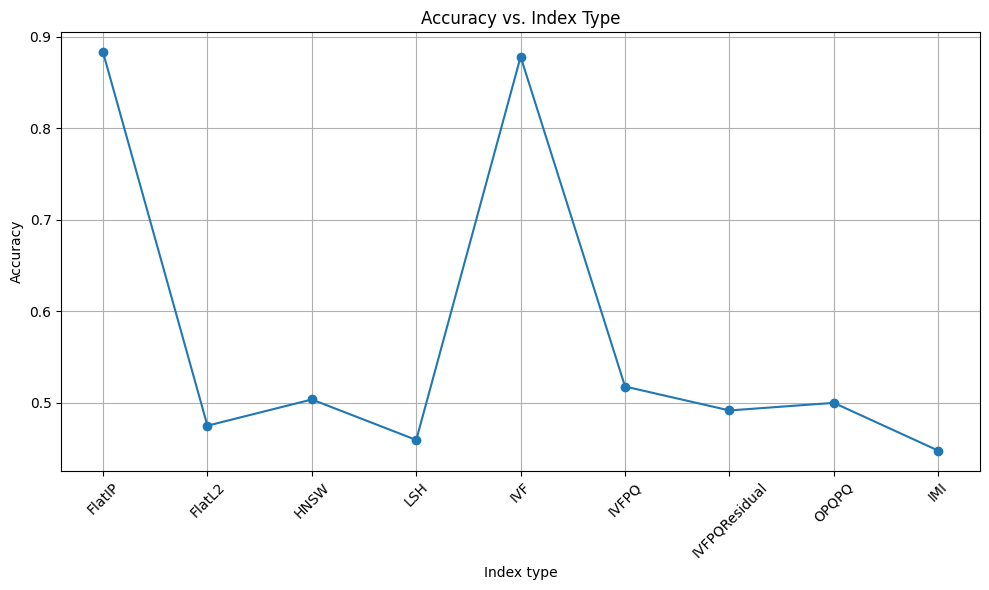

In [54]:
plt.figure(figsize=(10, 6))

plt.plot(deduplicators.keys(), list(map(lambda x: x['accuracy'], results)), marker='o')

plt.title('Accuracy vs. Index Type')
plt.xlabel('Index type')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

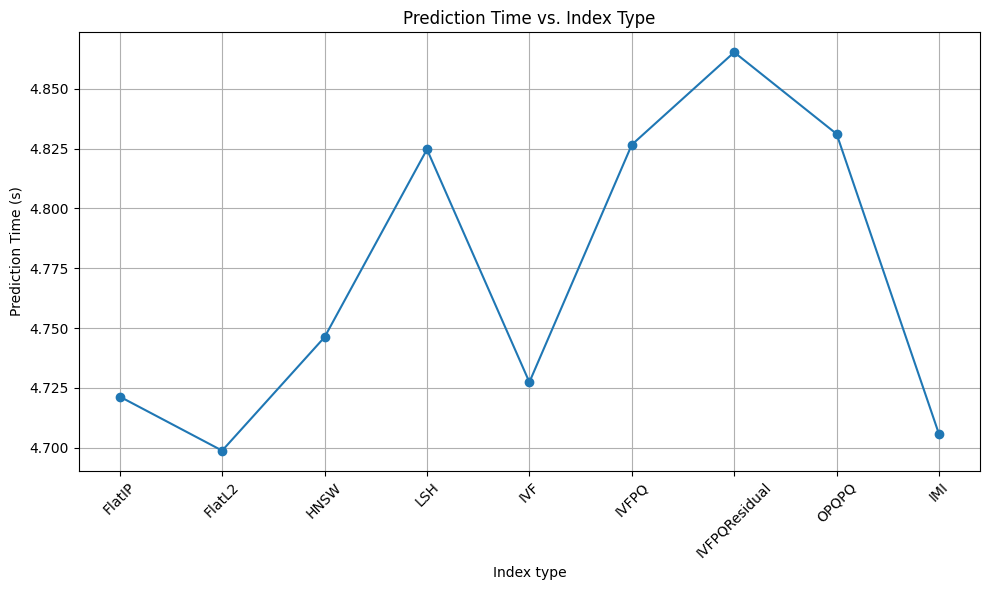

In [55]:
plt.figure(figsize=(10, 6))

plt.plot(deduplicators.keys(), list(map(lambda x: x['prediction_time_sec'], results)), marker='o')

plt.title('Prediction Time vs. Index Type')
plt.xlabel('Index type')
plt.ylabel('Prediction Time (s)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The best results are achieved by the `FlatIP` index, which also offers the lowest prediction time. It is closely followed by the `IVF` index, which provides a good balance between accuracy and efficiency.

## Final solution

The final solution combines the `FlatIP` index with the `sentence-transformers/paraphrase-MiniLM-L3-v2` model, providing the best overall performance in terms of deduplication effectiveness and efficiency. The achieved results are presented below.

In [5]:
deduplicator = EmbeddingDeduplicator(
    model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
    dimension=384,
    threshold=0.96,
    top_k=3,
    bacth_size=256
)
benchmark = Benchmark(deduplicator)
metrics = benchmark.evaluate(texts, labels, verbose=True)

Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92749
Precision                   0.98256
Recall                      0.87043
F1                          0.92310
Prediction_time_sec         6.00272
Samples                  9347.00000
Duplicates               4623.00000


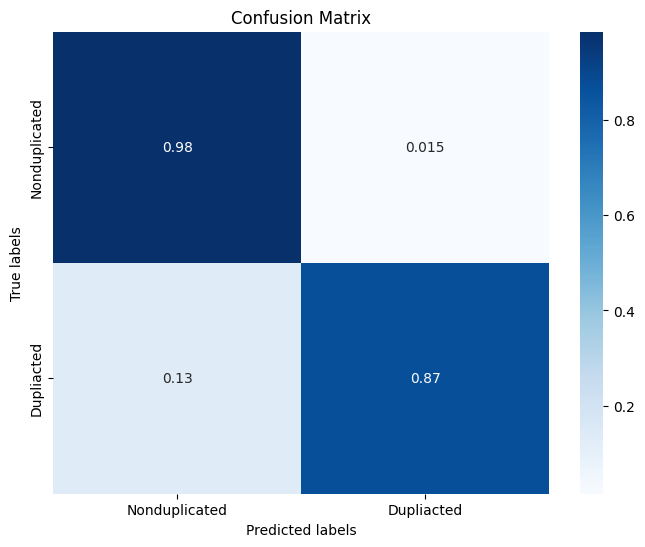

In [6]:
plot_confusion_matrix(y_pred=deduplicator.predict(texts), y_true=labels)